In [349]:
#import statements
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
import numpy as np
from sklearn import model_selection
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import math
from tensorflow import keras
from tensorflow.keras.models import Sequential
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

Cleaning the data for modeling:

In [350]:
#reding in data csv file
data = pd.read_csv("Final_Property_Features_Data.csv")

In [351]:
#filling na cols with mean or median col values
data['Stories'] = data['Stories'].fillna(data['Stories'].median())
data['Lot Area'] = data['Lot Area'].fillna(data['Lot Area'].mean())
data['beds'] = data['beds'].fillna(data['beds'].mean())
data['baths'] = data['baths'].fillna(data['baths'].mean())
data['Year Built'] = data['Year Built'].fillna(data['Year Built'].median())

Text(0, 0.5, 'Property Price')

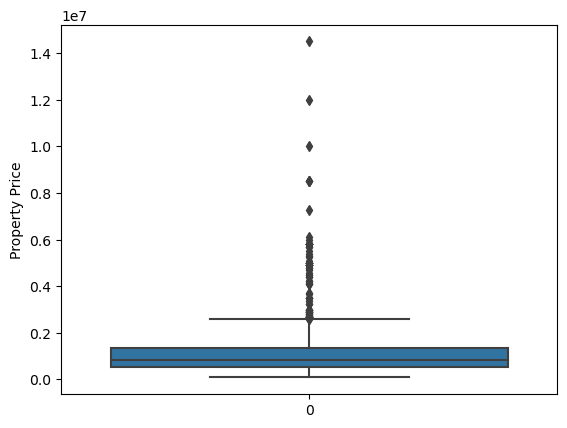

In [352]:
#visualizing outlier prices
sns.boxplot(data['price'])
plt.ylabel("Property Price")

In [353]:
#removing outlier prices
data = data[data['price'] < 2500000]

In [354]:
#dropping rows with nan price values
data = data.dropna(subset=['price'])

In [355]:
#binary encoding Zip Code
mlb = MultiLabelBinarizer()
zip_cols = mlb.fit_transform(data['Zip Code'].astype(str))
zip_df = pd.DataFrame(zip_cols)
zip_df.columns = ["zip_1","zip_2","zip_3","zip_4","zip_5","zip_6","zip_7","zip_8","zip_9","zip_10","zip_11","zip_12"]
data.reset_index(drop=True, inplace=True)
data = pd.concat([data, zip_df], axis=1).drop('Zip Code', axis=1)

In [356]:
#one hot encoding propery type
one_hot_encode_property = pd.get_dummies(data["Property Type"], prefix='Property')
data = pd.concat([data, one_hot_encode_property ], axis=1).drop('Property Type', axis=1)

In [357]:
#one hot encoding borough
one_hot_encode_property = pd.get_dummies(data["Borough"], prefix='Borough')
data = pd.concat([data, one_hot_encode_property ], axis=1).drop('Borough', axis=1)

In [358]:
#defining features array and output price array
x = data.loc[:, ~data.columns.isin(['price','links'])]
y = data["price"]

In [359]:
X_test, X_train, y_test, y_train = [], [], [], []
for ind, data in enumerate(x.iterrows()):
  if ind % 5 == 0:
    X_test.append(data[1])
    y_test.append(y[ind])
  else:
    X_train.append(data[1])
    y_train.append(y[ind])

In [360]:
#make into np arrays
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

Training a random forest regressor to predict property price:

In [361]:
#defining and fitting random forest model
regressor = RandomForestRegressor(n_estimators = 100, random_state = 0)
regressor.fit(X_train, y_train)  

RandomForestRegressor(random_state=0)

In [362]:
#evaluating random forest on train and test data
y_pred_train = regressor.predict(X_train)
y_pred_test = regressor.predict(X_test)

Text(0.5, 1.0, 'True vs. Predicted House Prices')

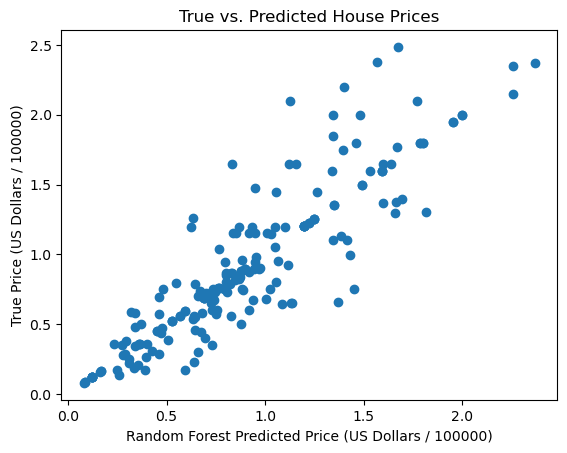

In [363]:
#plotting true vs. model predicitons 
fig = plt.scatter(y_pred_test/1000000,y_test/1000000)
plt.xlabel("Random Forest Predicted Price (US Dollars / 100000)")
plt.ylabel("True Price (US Dollars / 100000)")
plt.title("True vs. Predicted House Prices")

In [364]:
#evaluating metrics
print('Train AE : %.3f'%mean_absolute_error(y_train, y_pred_train))
print('Test AE : %.3f'%mean_absolute_error(y_test, y_pred_test))

print('Train R^2     : %.3f'%r2_score(y_train, y_pred_train))
print('Test R^2     : %.3f'%r2_score(y_test, y_pred_test))

Train AE : 58484.728
Test AE : 145126.082
Train R^2     : 0.960
Test R^2     : 0.801


Text(0.5, 1.0, 'Feature Importance')

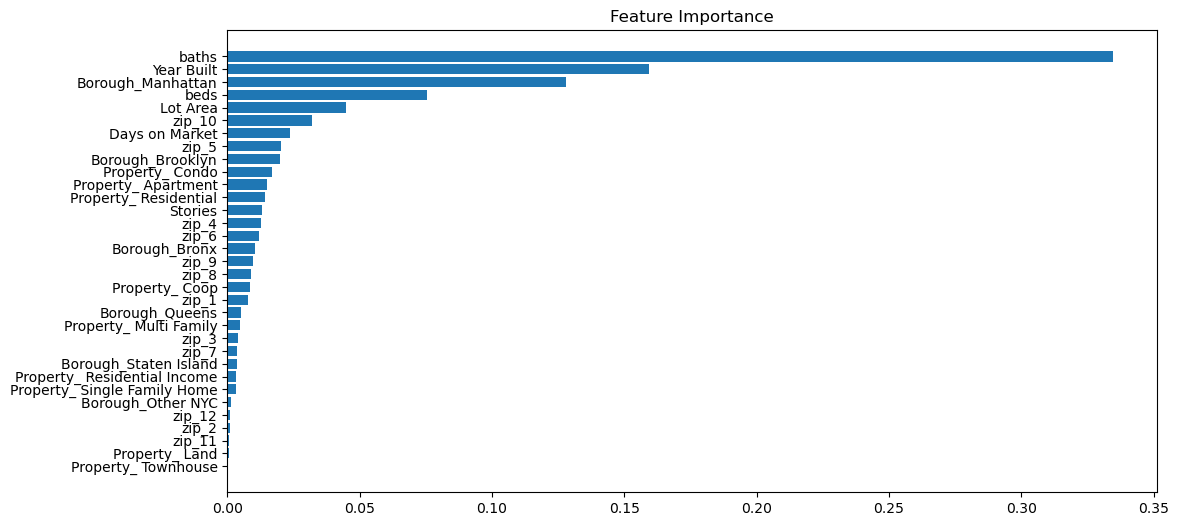

In [365]:
#plotting feature importance
feature_importance = regressor.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
fig.patch.set_facecolor('white')
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(x.columns)[sorted_idx])
plt.title('Feature Importance')

In [366]:
#getting difference between true and predcited price and appending difference column to original pandas data frame
#the lower the difference value, theoretically, the more undervalues the house
#diff = []
#[diff.append(y_train[i] - y_pred_test[i]) for i in range(len(y_pred_test))]
    
#pred_df = data[-len(X_test):]
#pred_df["Predicted_Difference"]= diff
#pred_df = pred_df.sort_values(by = 'Predicted_Difference')

Training a vanilla neaural network to predict property price

In [369]:
#defining and compiling model
model = Sequential([
    Dense(len(X_train), activation='relu'),
    Dense(256, activation='relu'),
    Dense(256, activation='relu'),
    Dense(1, activation='linear')
])
model.compile(optimizer='adam',
                loss='mean_absolute_error',
                metrics=['mean_absolute_error'])

In [370]:
#fitting neural network
#my_callbacks = [keras.callbacks.EarlyStopping(patience=10)]
history = model.fit(X_train, y_train, epochs = 1000, validation_split=0.2)

Epoch 1/1000


2022-12-08 16:51:14.938680: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - 1s 14ms/step - loss: 826562.2500 - mean_absolute_error: 826562.2500 - val_loss: 986010.6875 - val_mean_absolute_error: 986010.6875
Epoch 2/1000
20/21 [===========================>..] - ETA: 0s - loss: 768331.6875 - mean_absolute_error: 768331.6875

2022-12-08 16:51:15.458681: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - 0s 7ms/step - loss: 766815.5625 - mean_absolute_error: 766815.5625 - val_loss: 1181863.0000 - val_mean_absolute_error: 1181863.0000
Epoch 3/1000
21/21 [==============================] - 0s 7ms/step - loss: 752062.8125 - mean_absolute_error: 752062.8125 - val_loss: 1006568.3125 - val_mean_absolute_error: 1006568.3125
Epoch 4/1000
21/21 [==============================] - 0s 6ms/step - loss: 690704.6875 - mean_absolute_error: 690704.6875 - val_loss: 937646.6875 - val_mean_absolute_error: 937646.6875
Epoch 5/1000
21/21 [==============================] - 0s 7ms/step - loss: 570815.0000 - mean_absolute_error: 570815.0000 - val_loss: 627356.2500 - val_mean_absolute_error: 627356.2500
Epoch 6/1000
21/21 [==============================] - 0s 7ms/step - loss: 408475.9375 - mean_absolute_error: 408475.9375 - val_loss: 460188.9062 - val_mean_absolute_error: 460188.9062
Epoch 7/1000
21/21 [==============================] - 0s 7ms/step - loss: 414104.7812 - m

In [371]:
#evaluating neural network
model.evaluate(X_test, y_test)

7/7 [==============================] - 0s 10ms/step - loss: 278304.9688 - mean_absolute_error: 278304.9688


[278304.96875, 278304.96875]

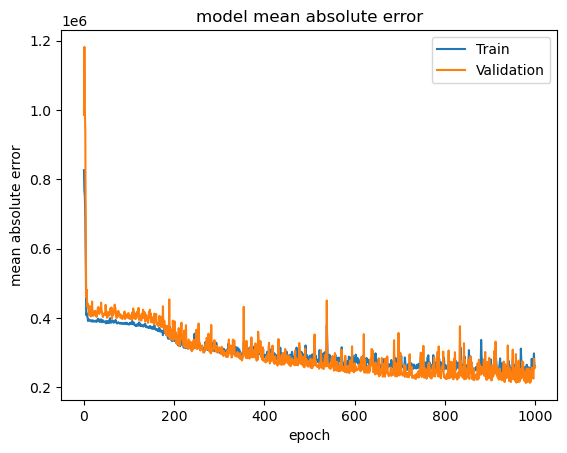

In [372]:
plt.plot(history.history['mean_absolute_error']);plt.plot(history.history['val_mean_absolute_error']);plt.title('model mean absolute error');plt.ylabel('mean absolute error');plt.xlabel('epoch');plt.legend(['Train', 'Validation'], loc='upper right')

Training a linear regression to predict property price:

In [377]:
#defining and training linear regression model
regression = LinearRegression()
regression.fit(X_train, y_train)

LinearRegression()

In [378]:
#predicting on train/test data
y_pred_train = regression.predict(X_train)
y_pred_test = regression.predict(X_test)

Text(0.5, 1.0, 'True vs. Predicted House Prices')

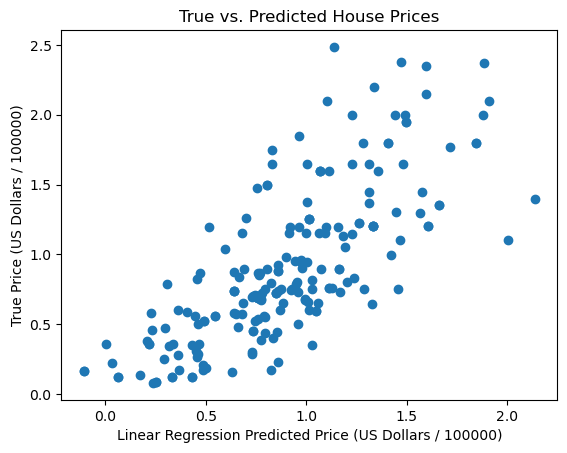

In [379]:
#plotting preds vs. true
fig = plt.scatter(y_pred_test/1000000,y_test/1000000)
plt.xlabel("Linear Regression Predicted Price (US Dollars / 100000)")
plt.ylabel("True Price (US Dollars / 100000)")
plt.title("True vs. Predicted House Prices")

In [380]:
#evaluating metrics
print('Train AE : %.3f'%mean_absolute_error(y_train, y_pred_train))
print('Test AE : %.3f'%mean_absolute_error(y_test, y_pred_test))

print('Train R^2     : %.3f'%r2_score(y_train, y_pred_train))
print('Test R^2     : %.3f'%r2_score(y_test, y_pred_test))

Train AE : 253719.499
Test AE : 275710.989
Train R^2     : 0.617
Test R^2     : 0.564
